<a href="https://colab.research.google.com/github/seriamedard/ASL_ResNet/blob/main/ASL_dev_local_50e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, utils, callbacks
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import (ImageDataGenerator,
                                                  load_img, img_to_array)
from sklearn.metrics import (classification_report, accuracy_score,precision_score,
                             recall_score,confusion_matrix,roc_curve,roc_auc_score,
                             confusion_matrix)  

# Preprocessing


In [ ]:
# Download data from kaggle using username and api key
#od.download("https://www.kaggle.com/datasets/grassknoted/asl-alphabet")

100%|██████████| 1.03G/1.03G [07:08<00:00, 2.57MB/s]


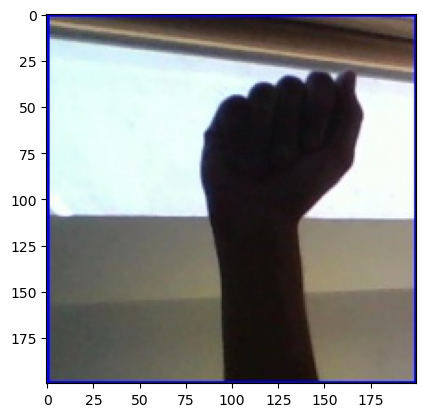

In [ ]:
# Test plot images
img=cv2.imread('./asl-alphabet/asl_alphabet_test/asl_alphabet_test/A_test.jpg')
img2 = img[:,:,::-1]
plt.imshow(img2)

In [ ]:
# Create Labels with contents

train_folder = './asl-alphabet//asl_alphabet_train/asl_alphabet_train'

all_data = []
for folder in os.listdir(train_folder):
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)


In [ ]:
data_df.head

<bound method NDFrame.head of       label                                               path
0         A  ./asl-alphabet//asl_alphabet_train/asl_alphabe...
1         A  ./asl-alphabet//asl_alphabet_train/asl_alphabe...
2         A  ./asl-alphabet//asl_alphabet_train/asl_alphabe...
3         A  ./asl-alphabet//asl_alphabet_train/asl_alphabe...
4         A  ./asl-alphabet//asl_alphabet_train/asl_alphabe...
...     ...                                                ...
86995     Z  ./asl-alphabet//asl_alphabet_train/asl_alphabe...
86996     Z  ./asl-alphabet//asl_alphabet_train/asl_alphabe...
86997     Z  ./asl-alphabet//asl_alphabet_train/asl_alphabe...
86998     Z  ./asl-alphabet//asl_alphabet_train/asl_alphabe...
86999     Z  ./asl-alphabet//asl_alphabet_train/asl_alphabe...

[87000 rows x 2 columns]>

In [ ]:
labels = sorted(data_df['label'].unique())

*You need to add del_test.jpg in folder /asl_alphabet_test*

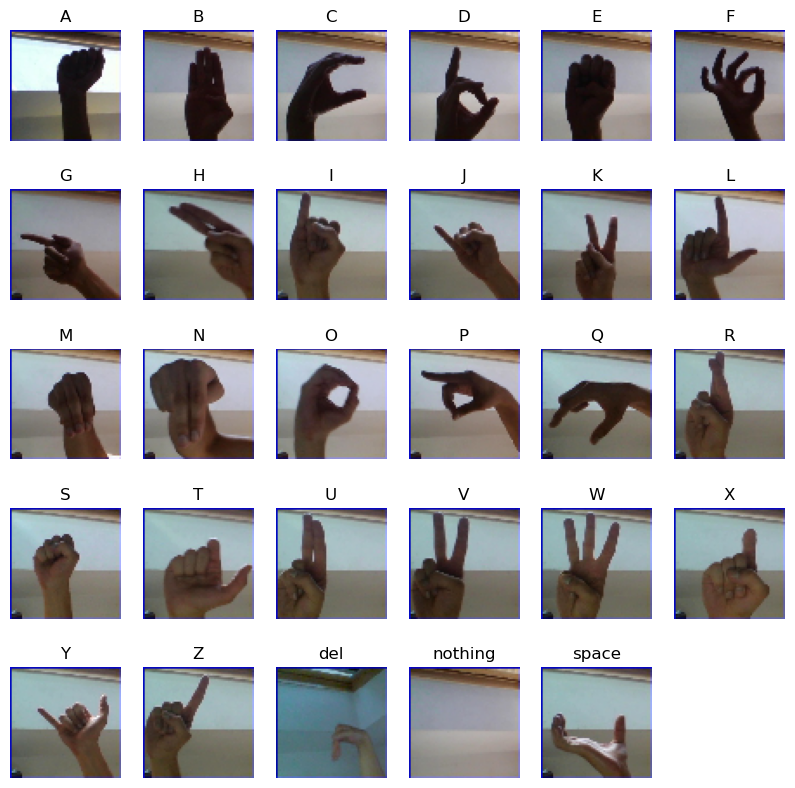

In [ ]:
# Plot Images test

test_dir = "./asl-alphabet/asl_alphabet_test/asl_alphabet_test/"
files_test = [f for f in os.listdir(test_dir)]
all_data_tests = [ test_dir + file for file in files_test]
all_data_tests = sorted(all_data_tests)
plt.figure(figsize=(10, 10))
i = 1
for img in all_data_tests:
    image = load_img(img, target_size = (64,64))
    ax = plt.subplot(5 , 6, i)
    plt.imshow(image)
    plt.title(labels[i-1])
    plt.axis("off")
    i = i + 1
    if  i == 30:
        break
plt.savefig("./figure/overview.jpg")
plt.show()

Split data

In [ ]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.20, random_state=42,stratify=x_train[['label']])

Resizing


In [ ]:
img_width, img_height = 64, 64
batch_size = 128
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0, zoom_range=0.2, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, horizontal_flip = True, vertical_flip=False)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False   
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)

holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Found 62640 validated image filenames belonging to 29 classes.
Found 15660 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


# Model from scratch


In [ ]:
base_model = ResNet50V2(input_shape=(64, 64, 3), include_top=False, weights="imagenet")
base_model.trainable = False ## Not trainable weights

In [ ]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

In [ ]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dropout_layer_1 = layers.Dropout(0.5)
prediction_layer = layers.Dense(29, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    prediction_layer
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 29)                14877     
                                                                 
Total params: 27,774,493
Trainable params: 4,209,693
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                        patience=5, restore_best_weights = True)

In [ ]:
classes = 29
epochs = 50
learning_rate = 0.0001

adam = Adam(learning_rate=learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True, callbacks = [earlystopping])

Epoch 1/50
490/490 [==============================] - 738s 1s/step - loss: 1.5638 - accuracy: 0.5344 - val_loss: 0.9406 - val_accuracy: 0.7305
Epoch 2/50
490/490 [==============================] - 723s 1s/step - loss: 1.3155 - accuracy: 0.6030 - val_loss: 0.7882 - val_accuracy: 0.7762
Epoch 3/50
490/490 [==============================] - 711s 1s/step - loss: 1.1724 - accuracy: 0.6424 - val_loss: 0.7058 - val_accuracy: 0.7942
Epoch 4/50
490/490 [==============================] - 710s 1s/step - loss: 1.0814 - accuracy: 0.6680 - val_loss: 0.6402 - val_accuracy: 0.8102
Epoch 5/50
490/490 [==============================] - 696s 1s/step - loss: 1.0152 - accuracy: 0.6866 - val_loss: 0.6113 - val_accuracy: 0.8158
Epoch 6/50
490/490 [==============================] - 696s 1s/step - loss: 0.9607 - accuracy: 0.7002 - val_loss: 0.5677 - val_accuracy: 0.8273
Epoch 7/50
490/490 [==============================] - 666s 1s/step - loss: 0.9098 - accuracy: 0.7157 - val_loss: 0.5518 - val_accuracy: 0.8324

## Metrics

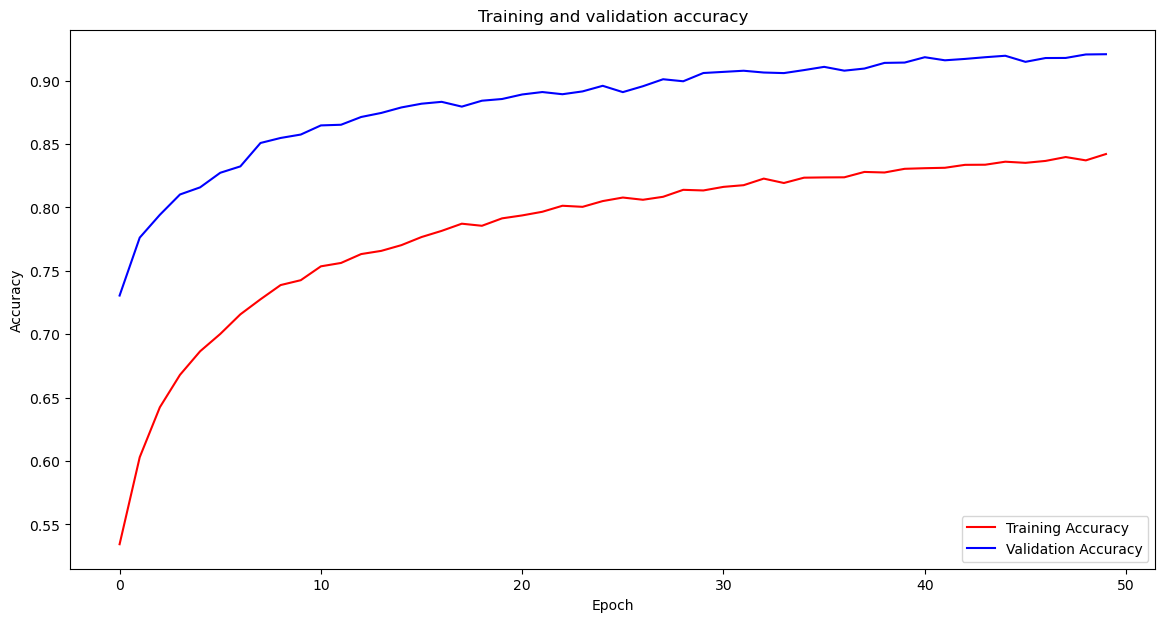

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

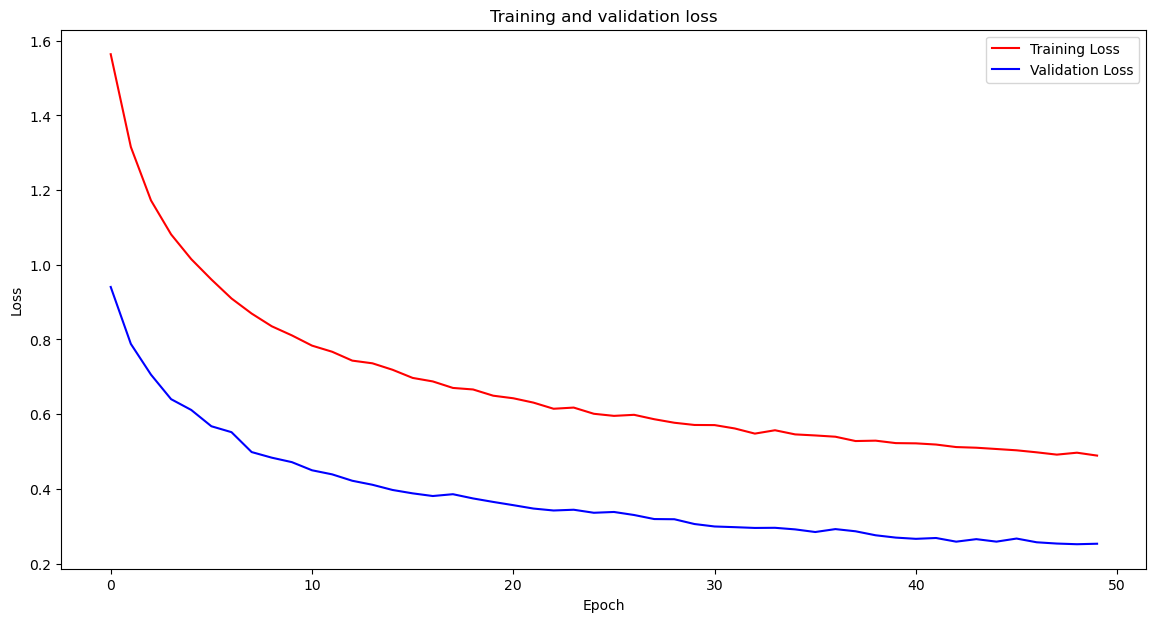

In [ ]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
predictions = model.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

68/68 [==============================] - 62s 884ms/step
              precision    recall  f1-score   support

           A       0.93      0.92      0.93       300
           B       0.89      0.98      0.93       300
           C       1.00      0.95      0.98       300
           D       0.96      0.97      0.97       300
           E       0.91      0.89      0.90       300
           F       0.98      0.97      0.97       300
           G       0.95      0.85      0.90       300
           H       0.95      0.95      0.95       300
           I       0.95      0.88      0.92       300
           J       0.98      0.98      0.98       300
           K       0.96      0.90      0.93       300
           L       0.98      0.97      0.97       300
           M       0.88      0.92      0.90       300
           N       0.94      0.88      0.91       300
           O       0.97      0.95      0.96       300
           P       0.96      0.94      0.95       300
           Q       0.95  

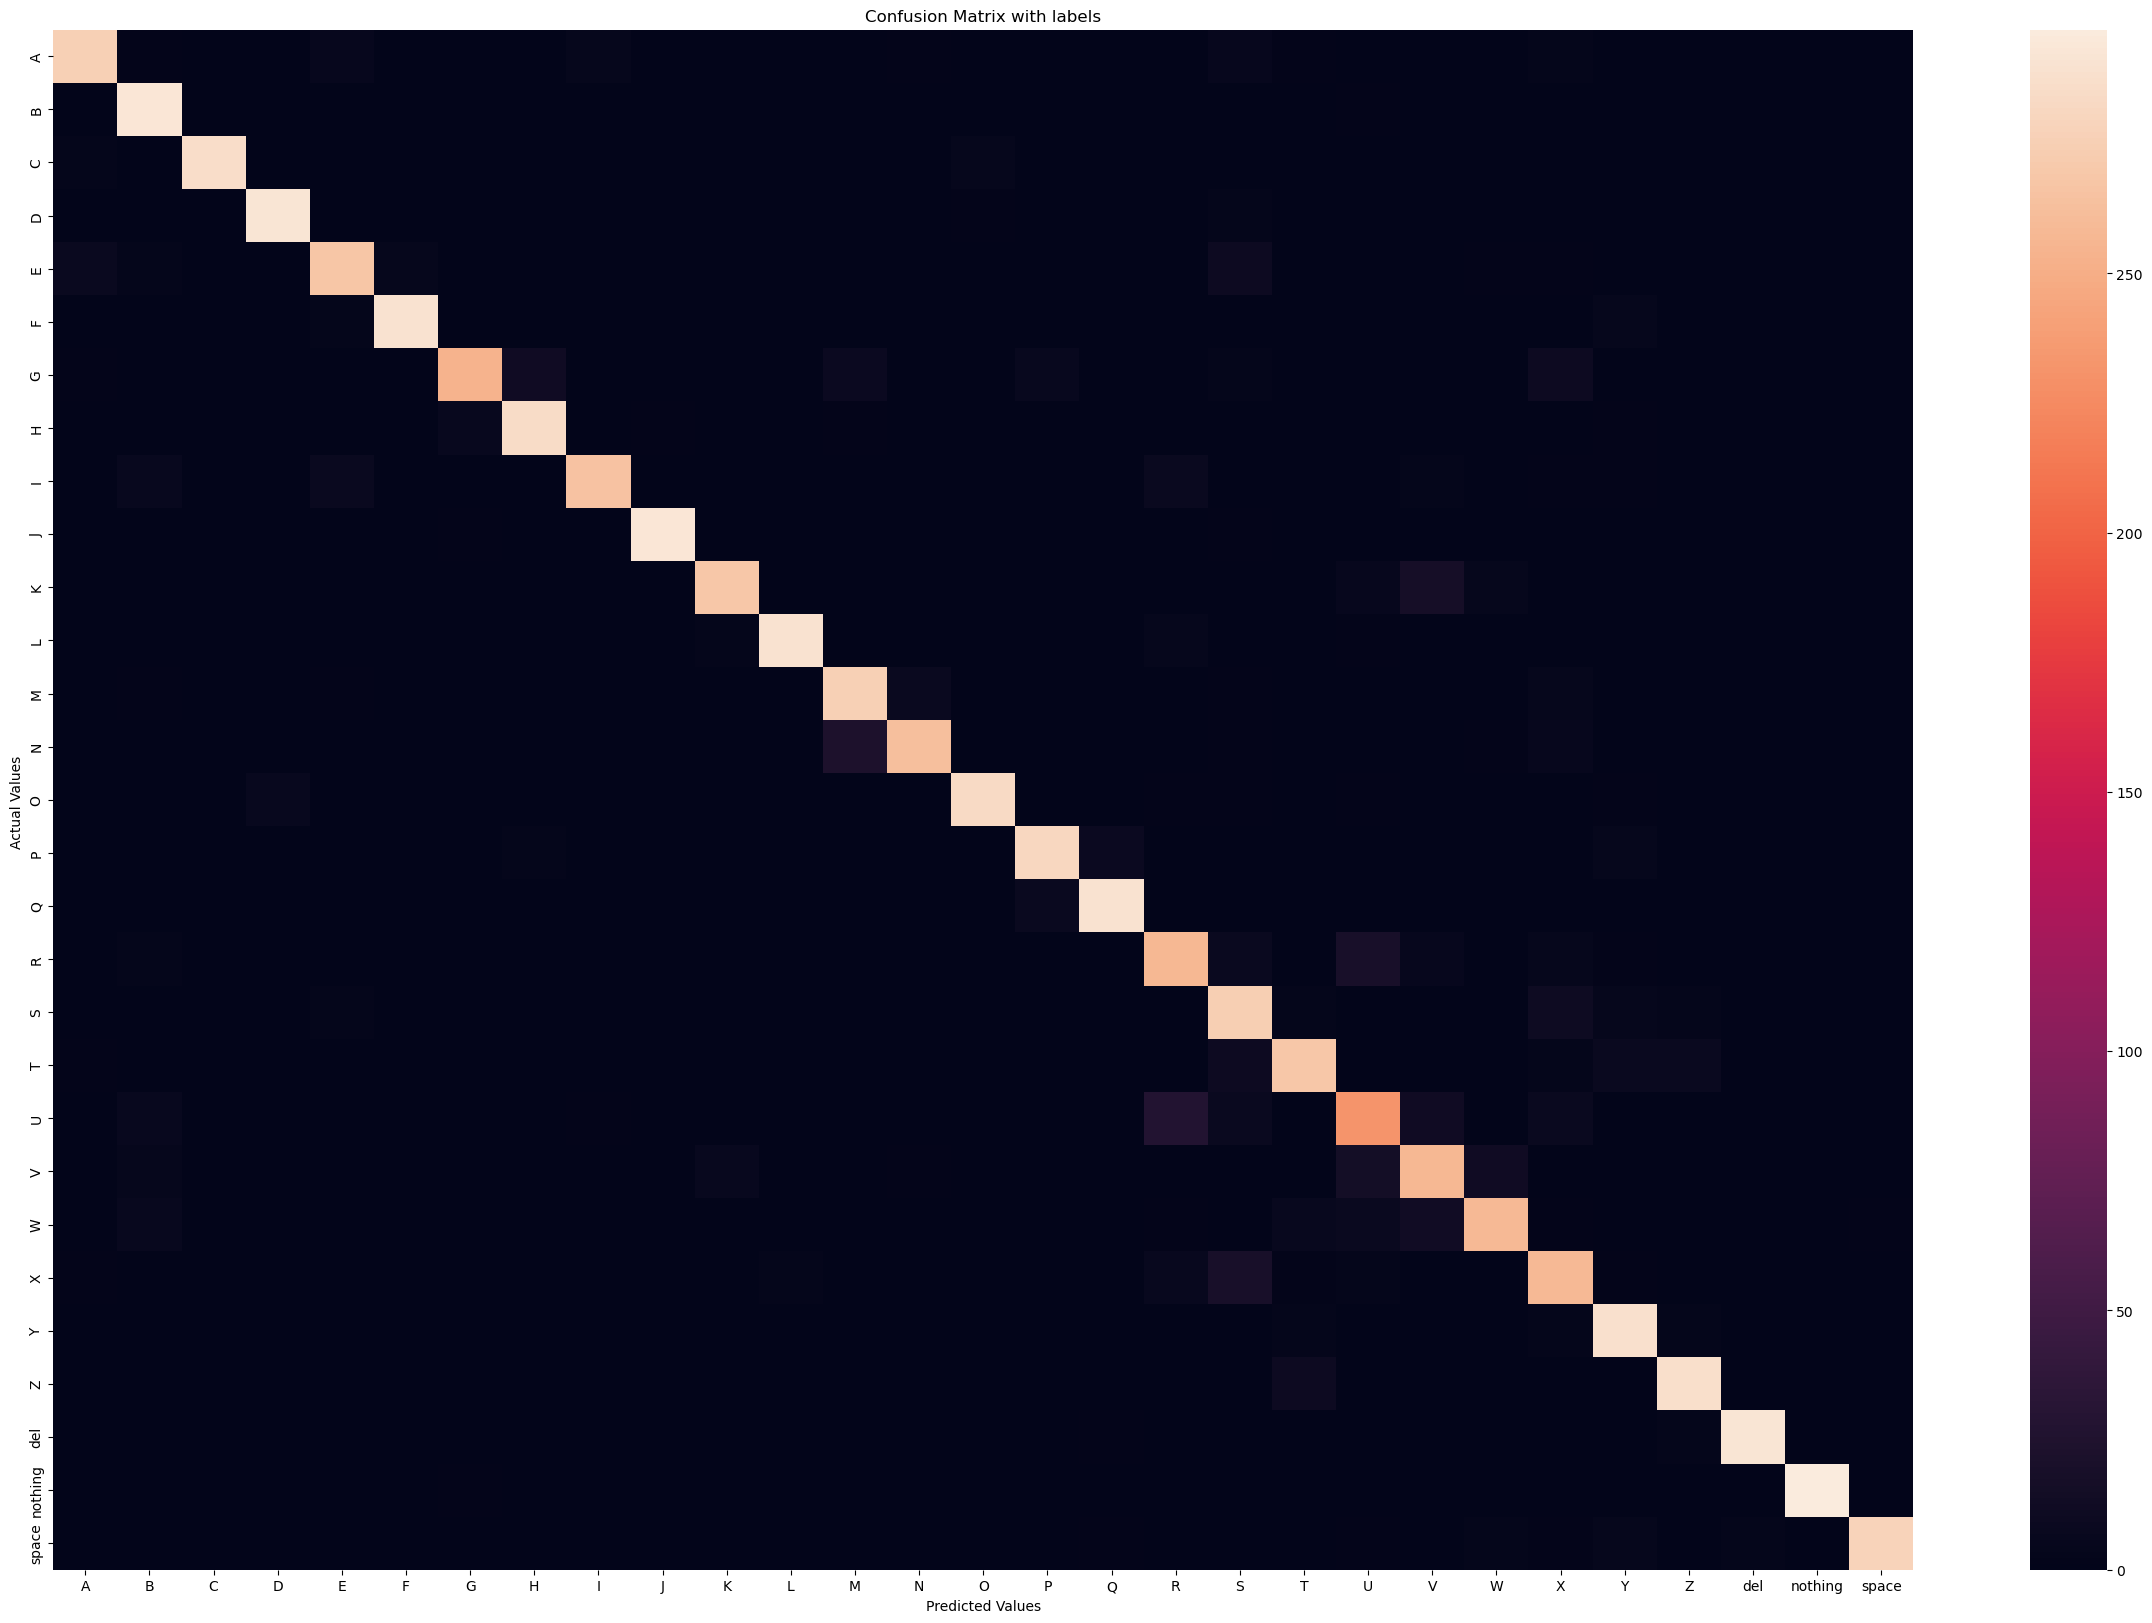

In [ ]:
plt.figure(figsize=(30, 20))

ax = sns.heatmap(confusion_matrix(true_classes,predicted_classes))
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

In [ ]:
model.save('./model/ResNet50V2-asl-50e.h5')

In [ ]:
json_model = model.to_json()

with open('ResNet50V2-asl-50e.json', 'w') as json_file:
    json_file.write(json_model)

In [ ]:
confusion = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[221   1   0   0  12   3   4   1   2   1   0   2   4   0   0   0   1   1
   20   6   0   1   2   4   2   7   3   0   2]
 [  4 210   0   0   8   0   0   5   4   3   2   0   3   2   5   0   0  19
    2   0  10   0   9   6   4   3   0   0   1]
 [  0   2 212   1   0   0   6   7   0   0   0   2   3   0   3   8  25   1
    4   0   0   0   0   1   4   1  10   1   9]
 [  0   3   7 237   0  10   1   0   4   1   7   3   1   0  11   0   1   4
    1   0   0   1   3   0   1   1   0   0   3]
 [ 20  12   0   4 141  11   7   2  12   0   4   4  12   7   0   0   0   1
   16  11   7   0   3  15   6   4   1   0   0]
 [  2   1   4   5   8 234   2   0   2   0   1   5   3   0   3   2   0   3
    6   1   0   0   5   1   7   5   0   0   0]
 [  4   3   1   0   0   0 224  13   0  14   1   0   1   0   0   0   5   1
    6   2   0   0   0  12   6   3   1   3   0]
 [  1   0   1   0   1   0  37 221   0  21   0   0   0   0   0   0   2   1
    2   0   0   0   0   1   3   0   2   4   3]
 [  3   7   0 

<AxesSubplot:>

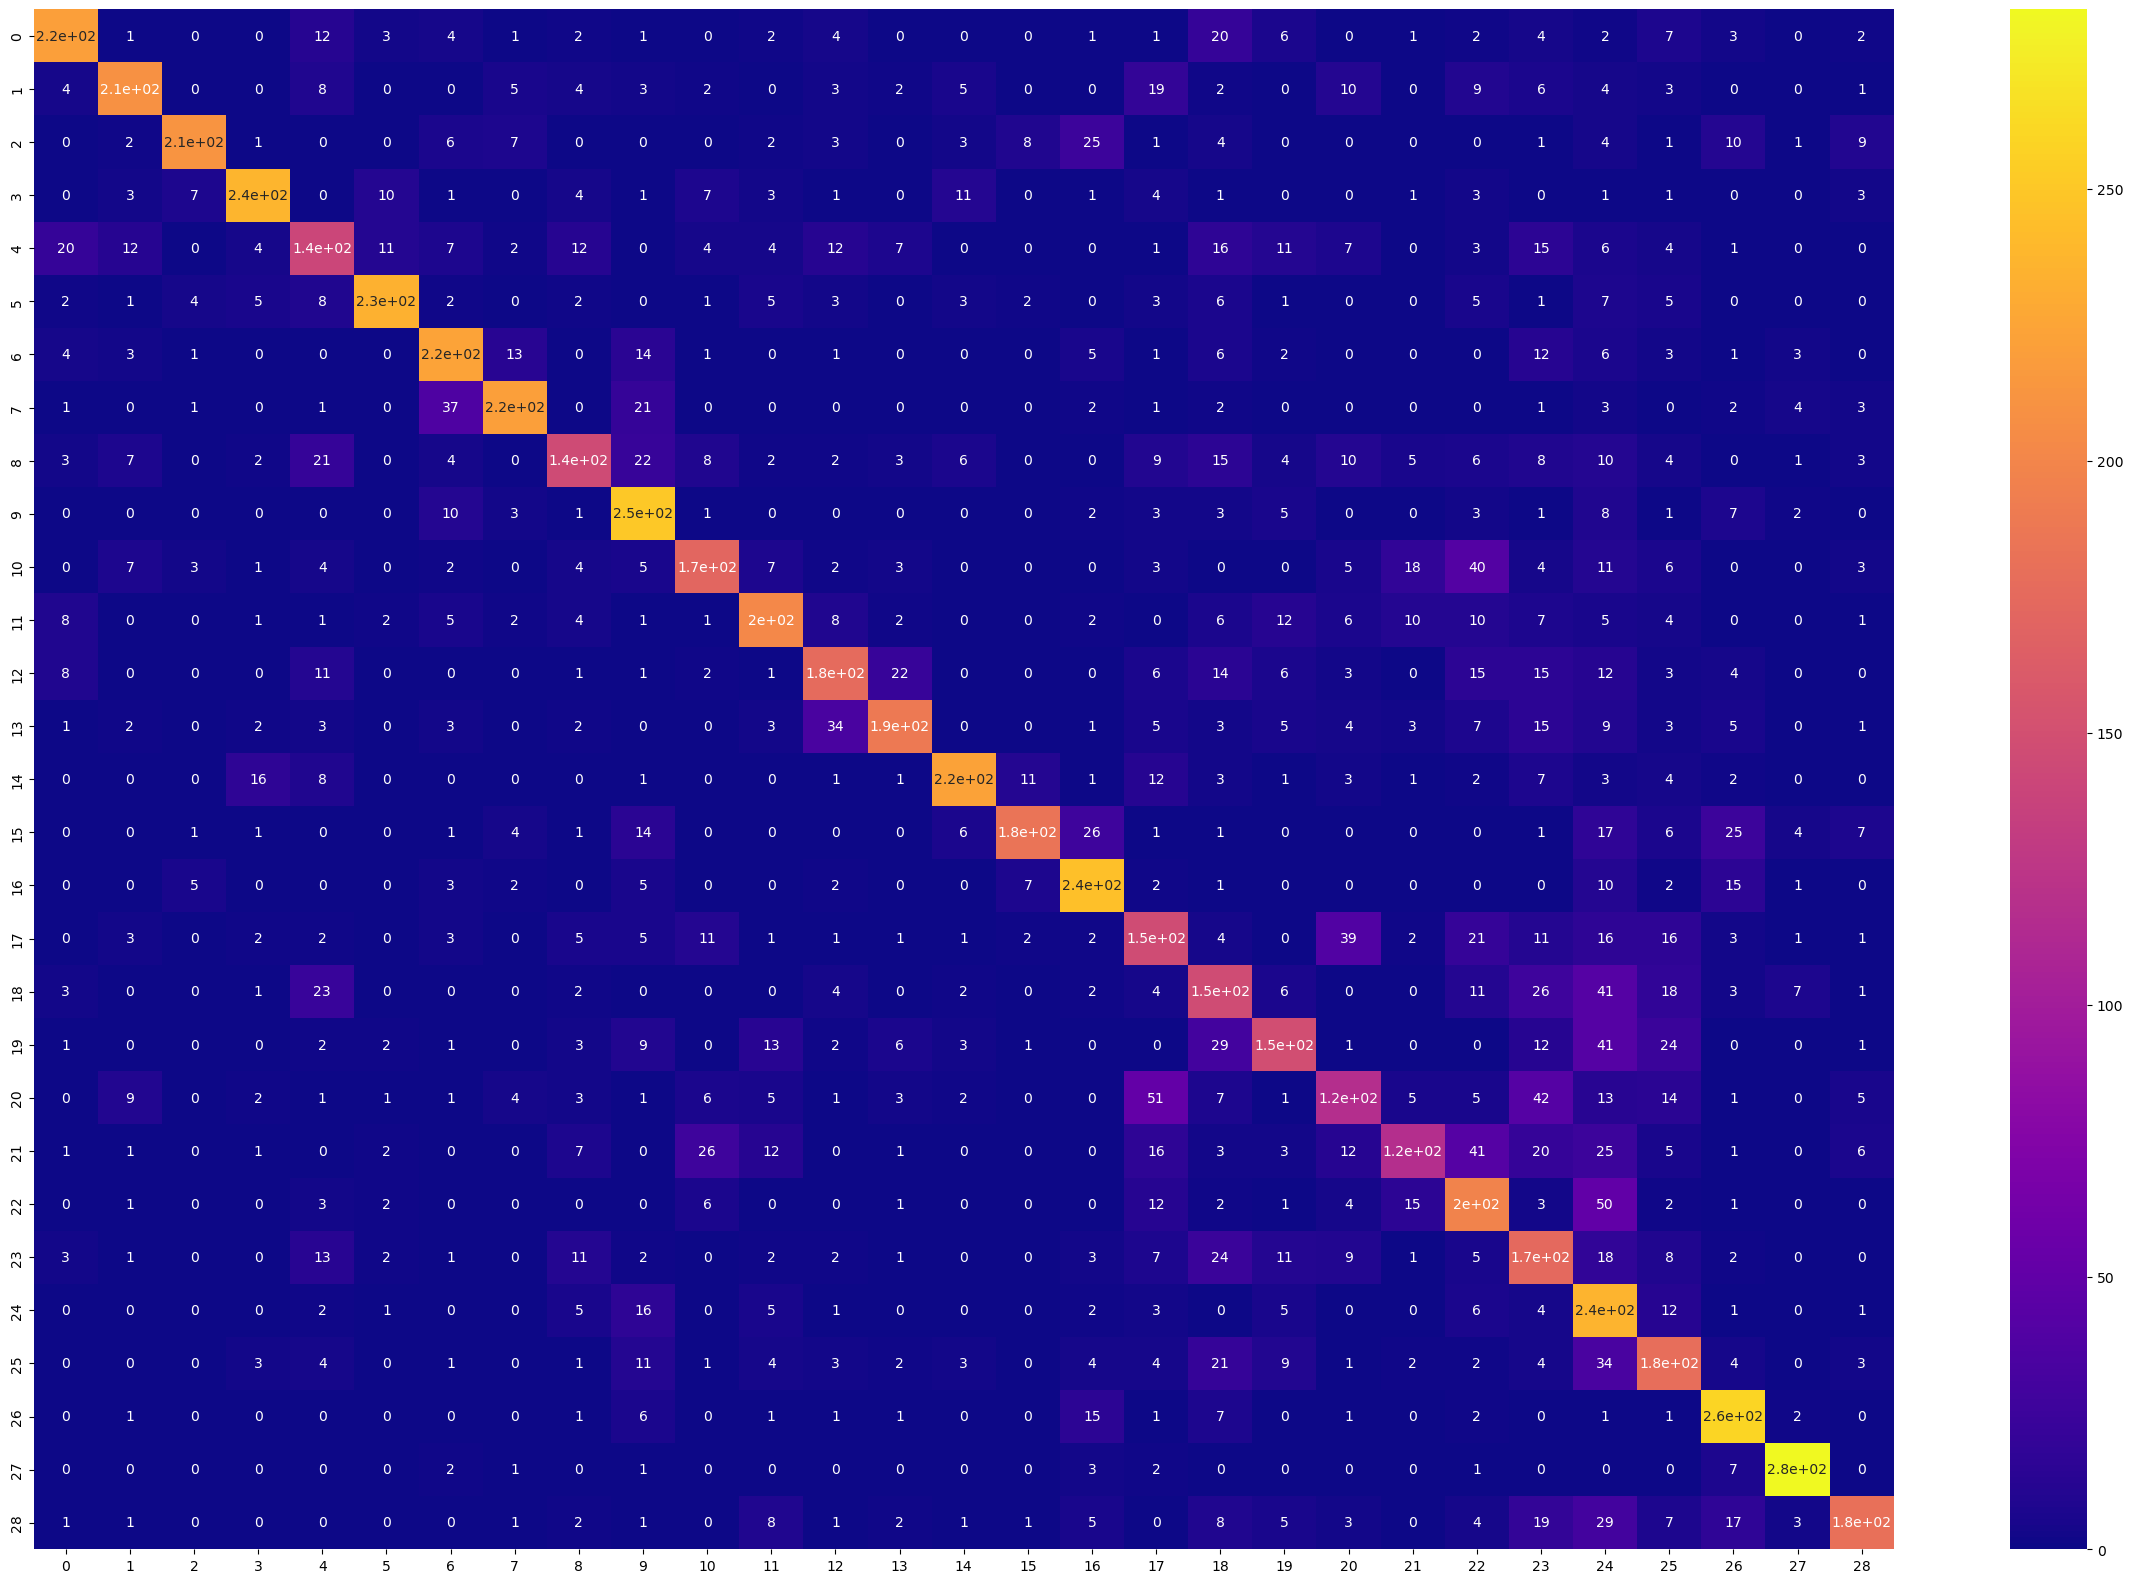

In [ ]:
plt.figure(figsize=(30, 20))
sns.heatmap(confusion, cmap="plasma", annot=True)

*Conclusion*


##  Predictions

In [ ]:
# Load model
model_50 = models.load_model('./model/ResNet50V2-asl-50e.h5')

In [ ]:
def predictions(filesPath, model):
    images = [load_img(img, target_size = (64,64)) for img in filesPath ]
    # convert image to array
    transform_image = [img_to_array(img) for img in images]
    # Expand dimension
    transform_image = [np.expand_dims(transform_, axis=0) for transform_ in transform_image]
    # Scale
    transform_image = [preprocess_input(transform_.copy()) for transform_ in transform_image]
    transform_image = np.array(transform_image) / 255.0
    # Predict
    predictions = [model.predict(transform_) for transform_ in transform_image]
    return predictions
    


In [ ]:
def decode_label_pred(predictions, labels):
    all_pred = []
    for pred in predictions:
        index = np.argmax(pred)
        decode = {labels[index] : f'{np.max(pred)*100:.2f} %'}

        all_pred.append(decode)
    return all_pred
        


In [ ]:
decode = decode_label_pred(predictions(all_data_tests, model_50), labels)

In [ ]:
# Print true label and predicted label
def display_pred(labels,decode):
    print("True \t Predicted \t Percent\n")
    for l, x in zip(labels, decode):
        for y, z in x.items():
            print(f"{l} \t {y} \t {z}")

In [ ]:
display_pred(labels, decode)

True 	 Predicted 	 Percent

A 	 A 	 97.77 %
B 	 B 	 100.00 %
C 	 C 	 100.00 %
D 	 D 	 100.00 %
E 	 E 	 99.98 %
F 	 F 	 99.96 %
G 	 G 	 99.95 %
H 	 H 	 99.88 %
I 	 D 	 99.98 %
J 	 J 	 96.63 %
K 	 V 	 60.62 %
L 	 L 	 96.79 %
M 	 N 	 59.80 %
N 	 N 	 99.25 %
O 	 O 	 73.55 %
P 	 P 	 99.95 %
Q 	 Q 	 94.61 %
R 	 D 	 99.96 %
S 	 S 	 95.20 %
T 	 T 	 99.83 %
U 	 B 	 61.26 %
V 	 V 	 73.61 %
W 	 W 	 100.00 %
X 	 X 	 92.76 %
Y 	 Y 	 68.68 %
Z 	 L 	 95.45 %
del 	 del 	 94.91 %
nothing 	 nothing 	 99.33 %
space 	 space 	 68.56 %


# Realtime Predictions with opencv

In [ ]:
def predict(model,labels,frame):
    transform_image = img_to_array(image)
    transform_image = np.expand_dims(frame, axis=0)
    transform_image = preprocess_input(transform_image.copy())
    transform_image = transform_image / 255.0
    prediction = model.predict(transform_image)
    label = labels[np.argmax(prediction)]
    
    return label, np.max(prediction)*100

In [ ]:
# Load Model
model_2= models.load_model('./model/ResNet50V2-asl-50e.h5')

In [ ]:
def start_live(predict, model, labels):
    # initiate video capture
    cap=cv2.VideoCapture(0)
    #saving all the captured frames to a video file called 'live prediction'
    #out=cv2.VideoWriter(r'Downloads/VIDEOS.avi',cv2.VideoWriter_fourcc(*'MJPG'),10, (192*4,108*4)) 
    if not cap.isOpened():
            print("Cannot open camera")
            exit()    
    while(True):
        
        ret,img=cap.read() # grabbing each frame of webcam footage
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        img = cv2.resize(img,(192*4,108*4)) # resizing frame size, must match video output frame size
        cv2.rectangle(img, (32,32),(432,432),(0,255,0),2) # adding a rectangle to the image
        frame=cv2.resize(img[32:432,32:432],(64,64))
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        pred, percent = predict(model,labels,frame)
        
        #print(f'{pred}:\t {percent}') # live prediction of frame
        cv2.putText(img,'{} {:.2f}% res-net50V2'.format(pred,percent),(25,25),cv2.FONT_HERSHEY_SIMPLEX,0.9,(80,255,255),1)
        cv2.imshow('img', img) # output frame
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
start_live(predict,model_2,labels)

# Transfert Learning

### Build model with weights pre-trained

In [ ]:
res_model = ResNet50V2(
    include_top = False,
    weights = 'imagenet',
    input_shape=(64, 64, 3)
)


In [ ]:
# freeze layers
for layer in res_model.layers[:143]:
    layer.trainable = False

In [ ]:
model = models.Sequential()
model.add(res_model)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(29, activation='softmax'))



In [ ]:
check_point = callbacks.ModelCheckpoint(filepath="./model/ResNet50-TLV2.h5",
                                              monitor="val_acc",
                                              mode="max",
                                              save_best_only=True,
                                              )


In [ ]:
classes = 29
epochs = 15
learning_rate = 0.01
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
history = model.fit(train_generator, epochs=epochs, verbose=1,
                    validation_data=validation_generator,
                    shuffle=True,
                    callbacks=[check_point])


Epoch 1/15
490/490 [==============================] - 4003s 8s/step - loss: 2.7854 - accuracy: 0.1338 - val_loss: 2.0121 - val_accuracy: 0.2852
Epoch 2/15
490/490 [==============================] - 2509s 5s/step - loss: 1.5964 - accuracy: 0.4100 - val_loss: 1.0409 - val_accuracy: 0.5935
Epoch 3/15
490/490 [==============================] - 2114s 4s/step - loss: 1.1595 - accuracy: 0.5820 - val_loss: 0.5495 - val_accuracy: 0.7850
Epoch 4/15
490/490 [==============================] - 2095s 4s/step - loss: 0.8759 - accuracy: 0.7056 - val_loss: 0.3845 - val_accuracy: 0.8449
Epoch 5/15
490/490 [==============================] - 2106s 4s/step - loss: 0.7358 - accuracy: 0.7559 - val_loss: 0.3416 - val_accuracy: 0.8667
Epoch 6/15
490/490 [==============================] - 2098s 4s/step - loss: 0.6544 - accuracy: 0.7908 - val_loss: 0.2817 - val_accuracy: 0.8851
Epoch 7/15
490/490 [==============================] - 2097s 4s/step - loss: 0.5828 - accuracy: 0.8103 - val_loss: 0.2418 - val_accuracy:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

### Export model and load 

In [ ]:
# Export model
model.save("./model/ResNet50-TLV2.h5")

In [ ]:
model_tl = models.load_model('./model/ResNet50-TLV2.h5')

### Metrics

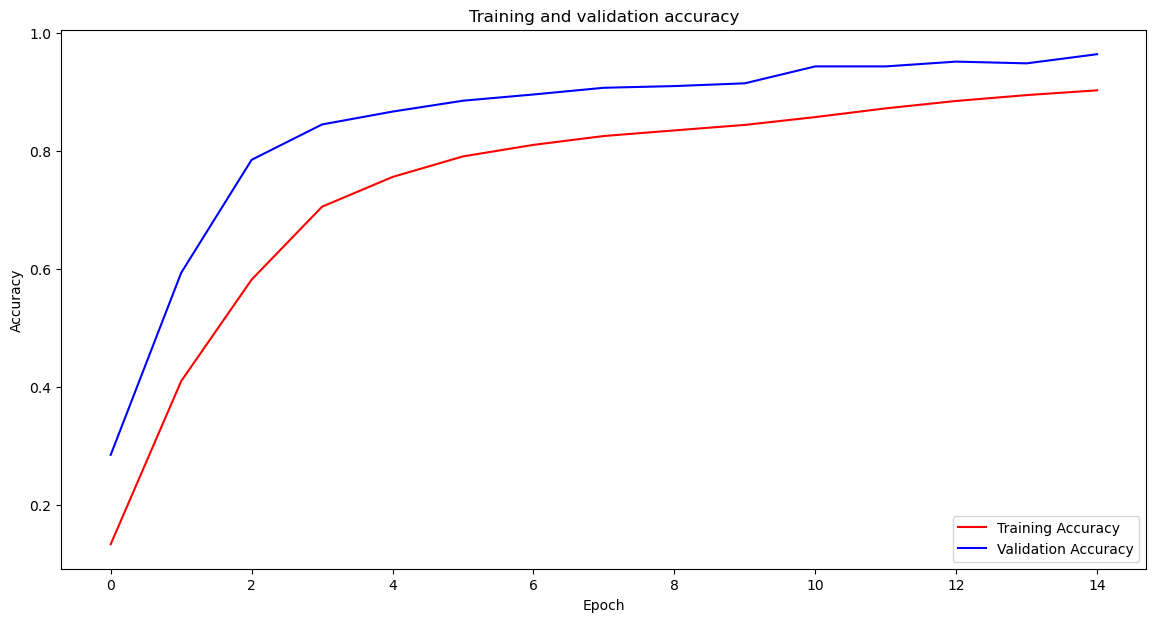

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

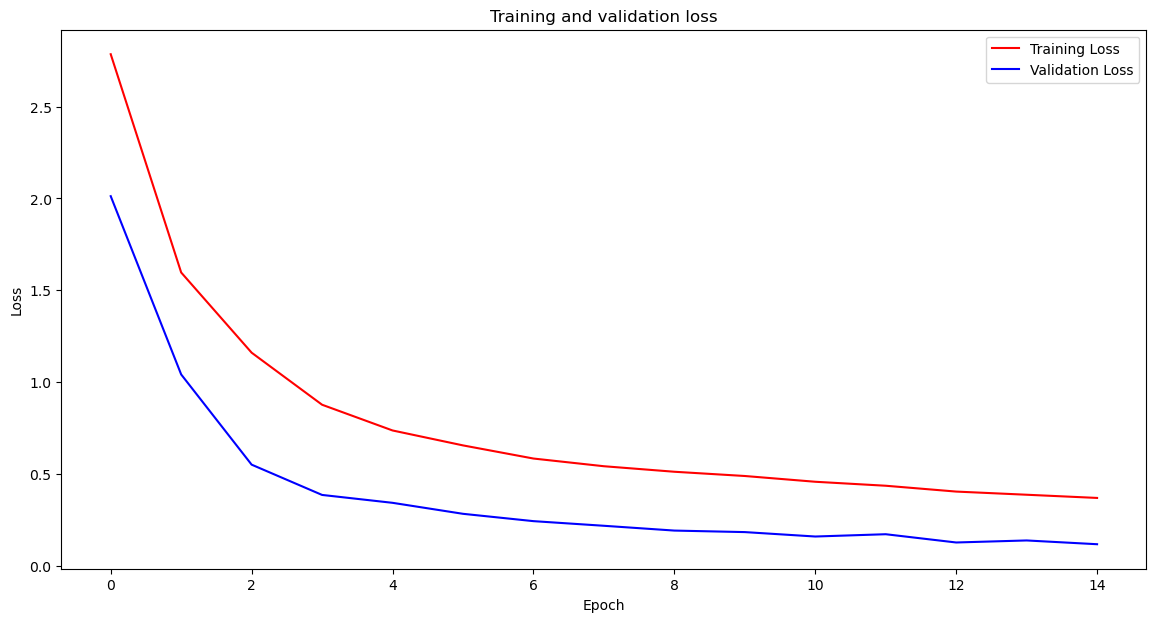

In [ ]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
predictions_ = model_tl.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions_, axis=-1)
predictions_ = np.argmax(predictions_, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

68/68 [==============================] - 115s 2s/step
              precision    recall  f1-score   support

           A       0.97      0.99      0.98       300
           B       0.97      1.00      0.99       300
           C       1.00      0.98      0.99       300
           D       1.00      1.00      1.00       300
           E       0.99      0.96      0.97       300
           F       1.00      1.00      1.00       300
           G       0.99      0.98      0.99       300
           H       0.97      1.00      0.98       300
           I       1.00      0.96      0.98       300
           J       1.00      0.99      1.00       300
           K       1.00      0.91      0.95       300
           L       1.00      1.00      1.00       300
           M       0.97      0.95      0.96       300
           N       0.94      0.97      0.96       300
           O       0.99      1.00      0.99       300
           P       0.96      1.00      0.98       300
           Q       1.00    

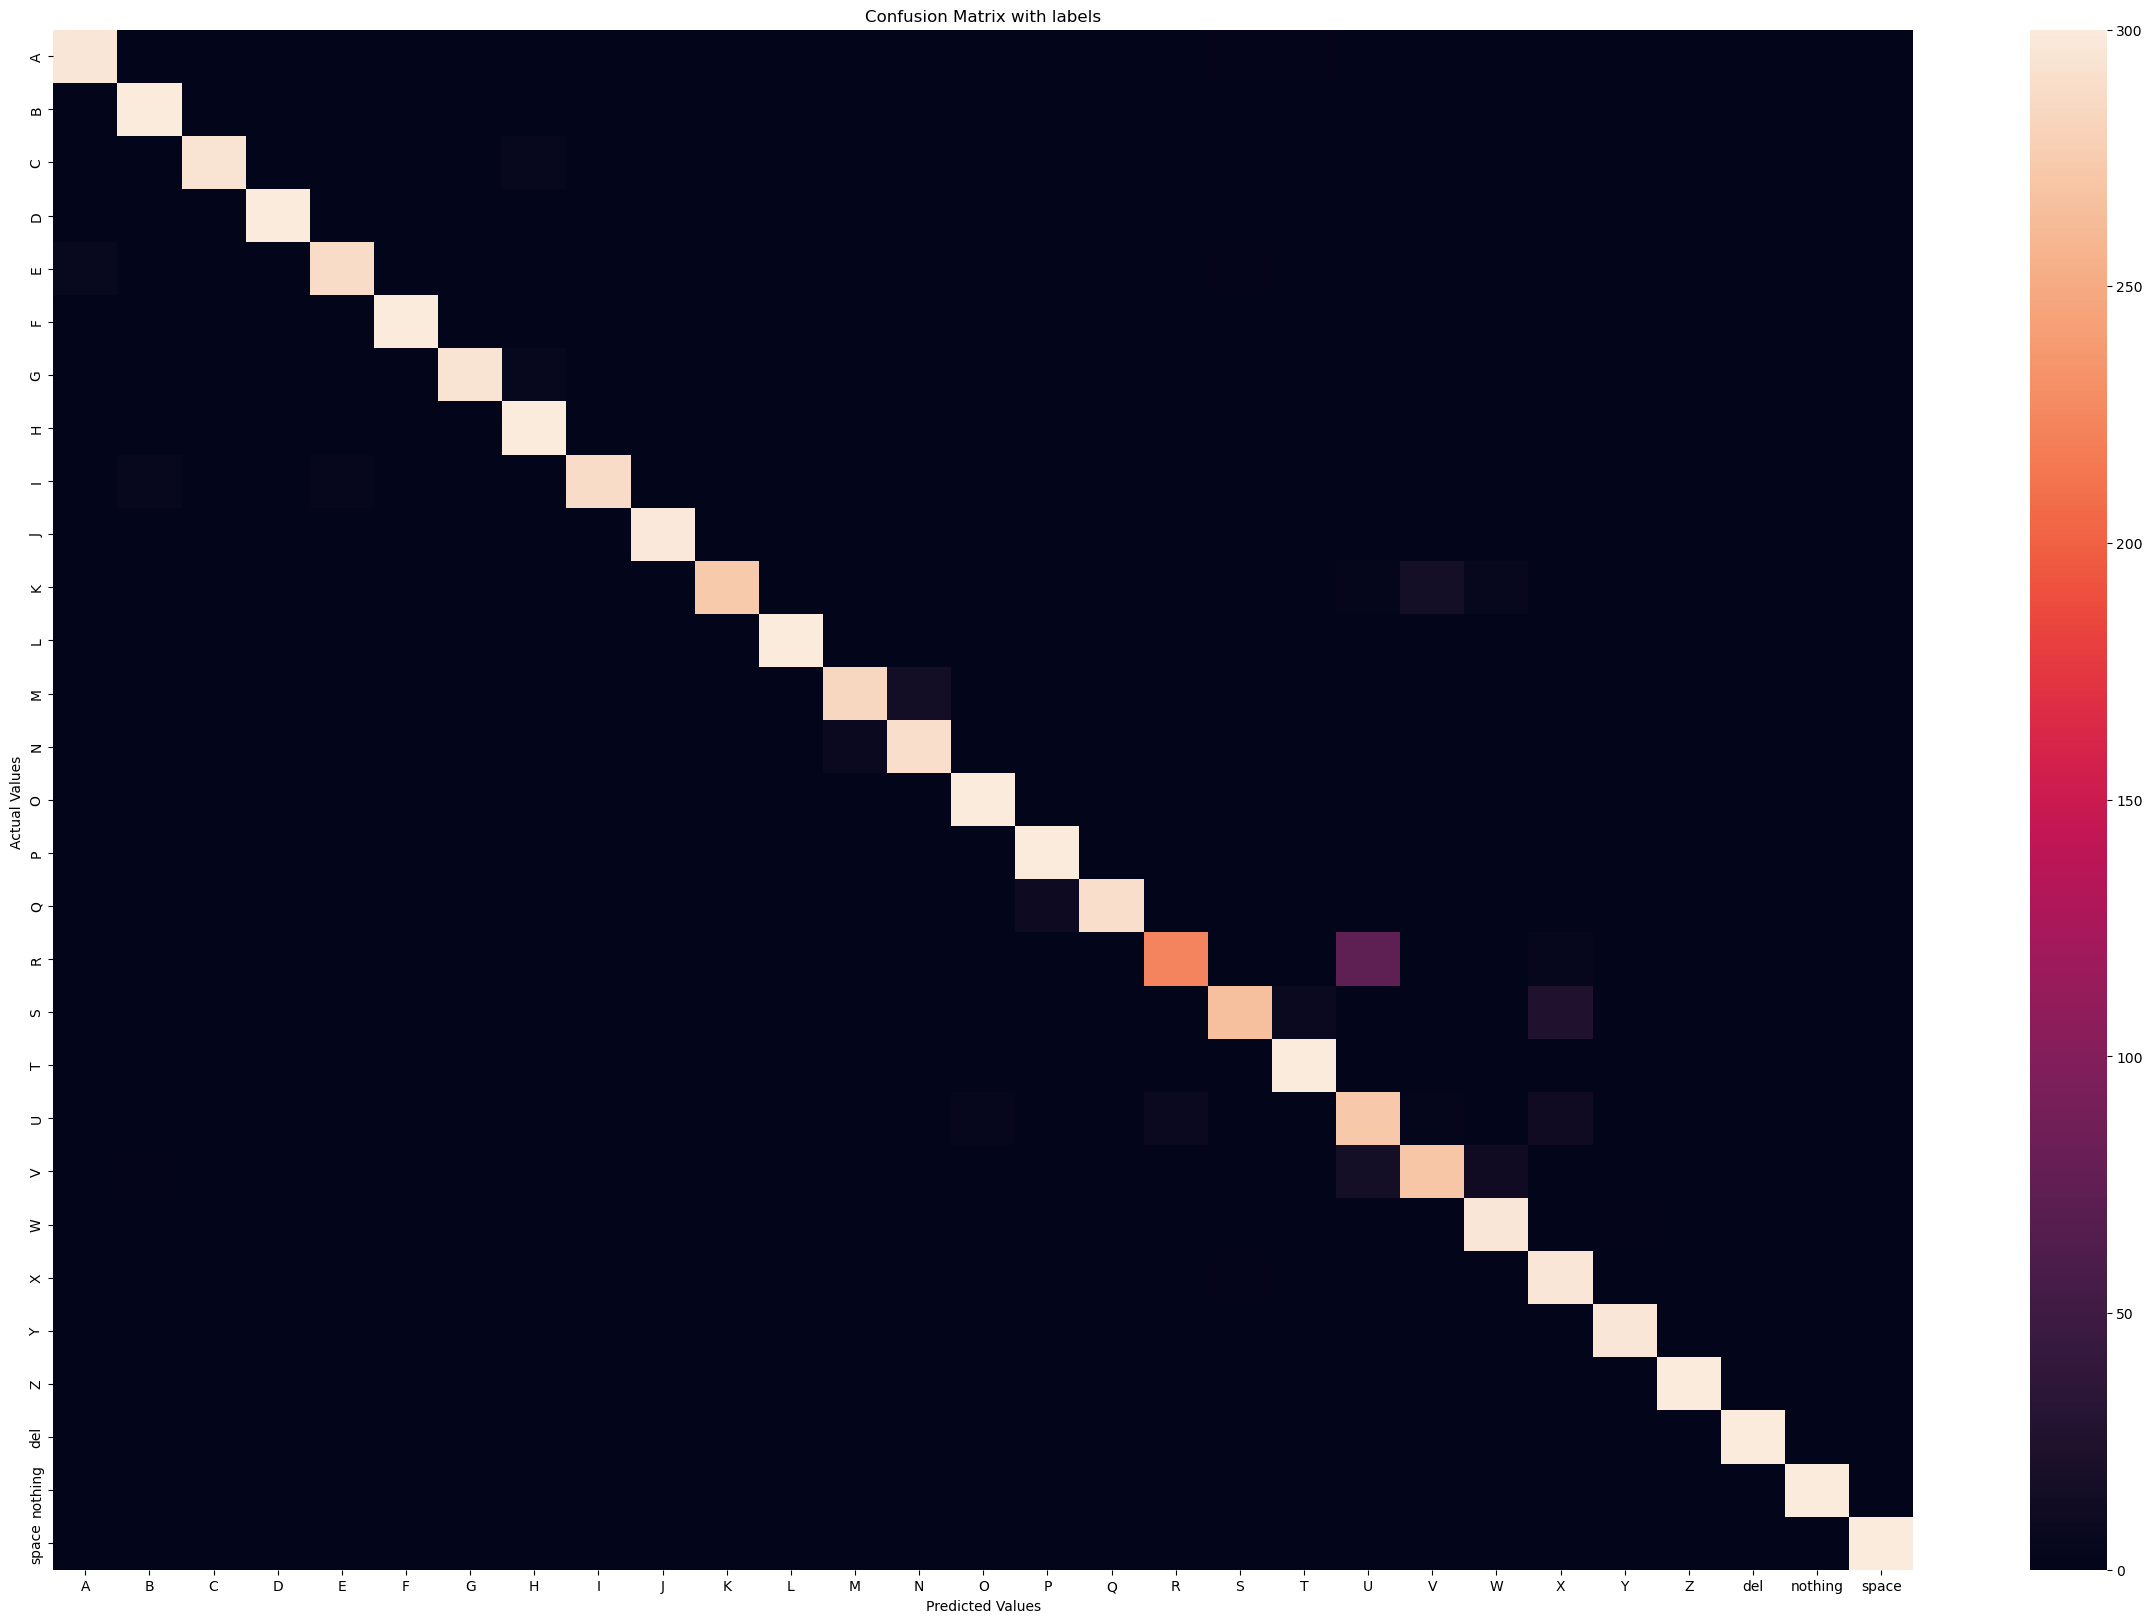

In [ ]:
plt.figure(figsize=(30, 20))

ax = sns.heatmap(confusion_matrix(true_classes,predicted_classes))
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

In [ ]:
confusion = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[296   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    2   2   0   0   0   0   0   0   0   0   0]
 [  0 300   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 294   0   0   0   0   5   0   0   0   0   0   0   0   1   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 300   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  7   0   0   0 288   1   0   0   0   0   0   0   1   0   0   0   0   0
    2   0   0   0   0   1   0   0   0   0   0]
 [  1   0   0   0   0 299   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 294   5   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0   0   0 300   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   5   0 

<AxesSubplot:>

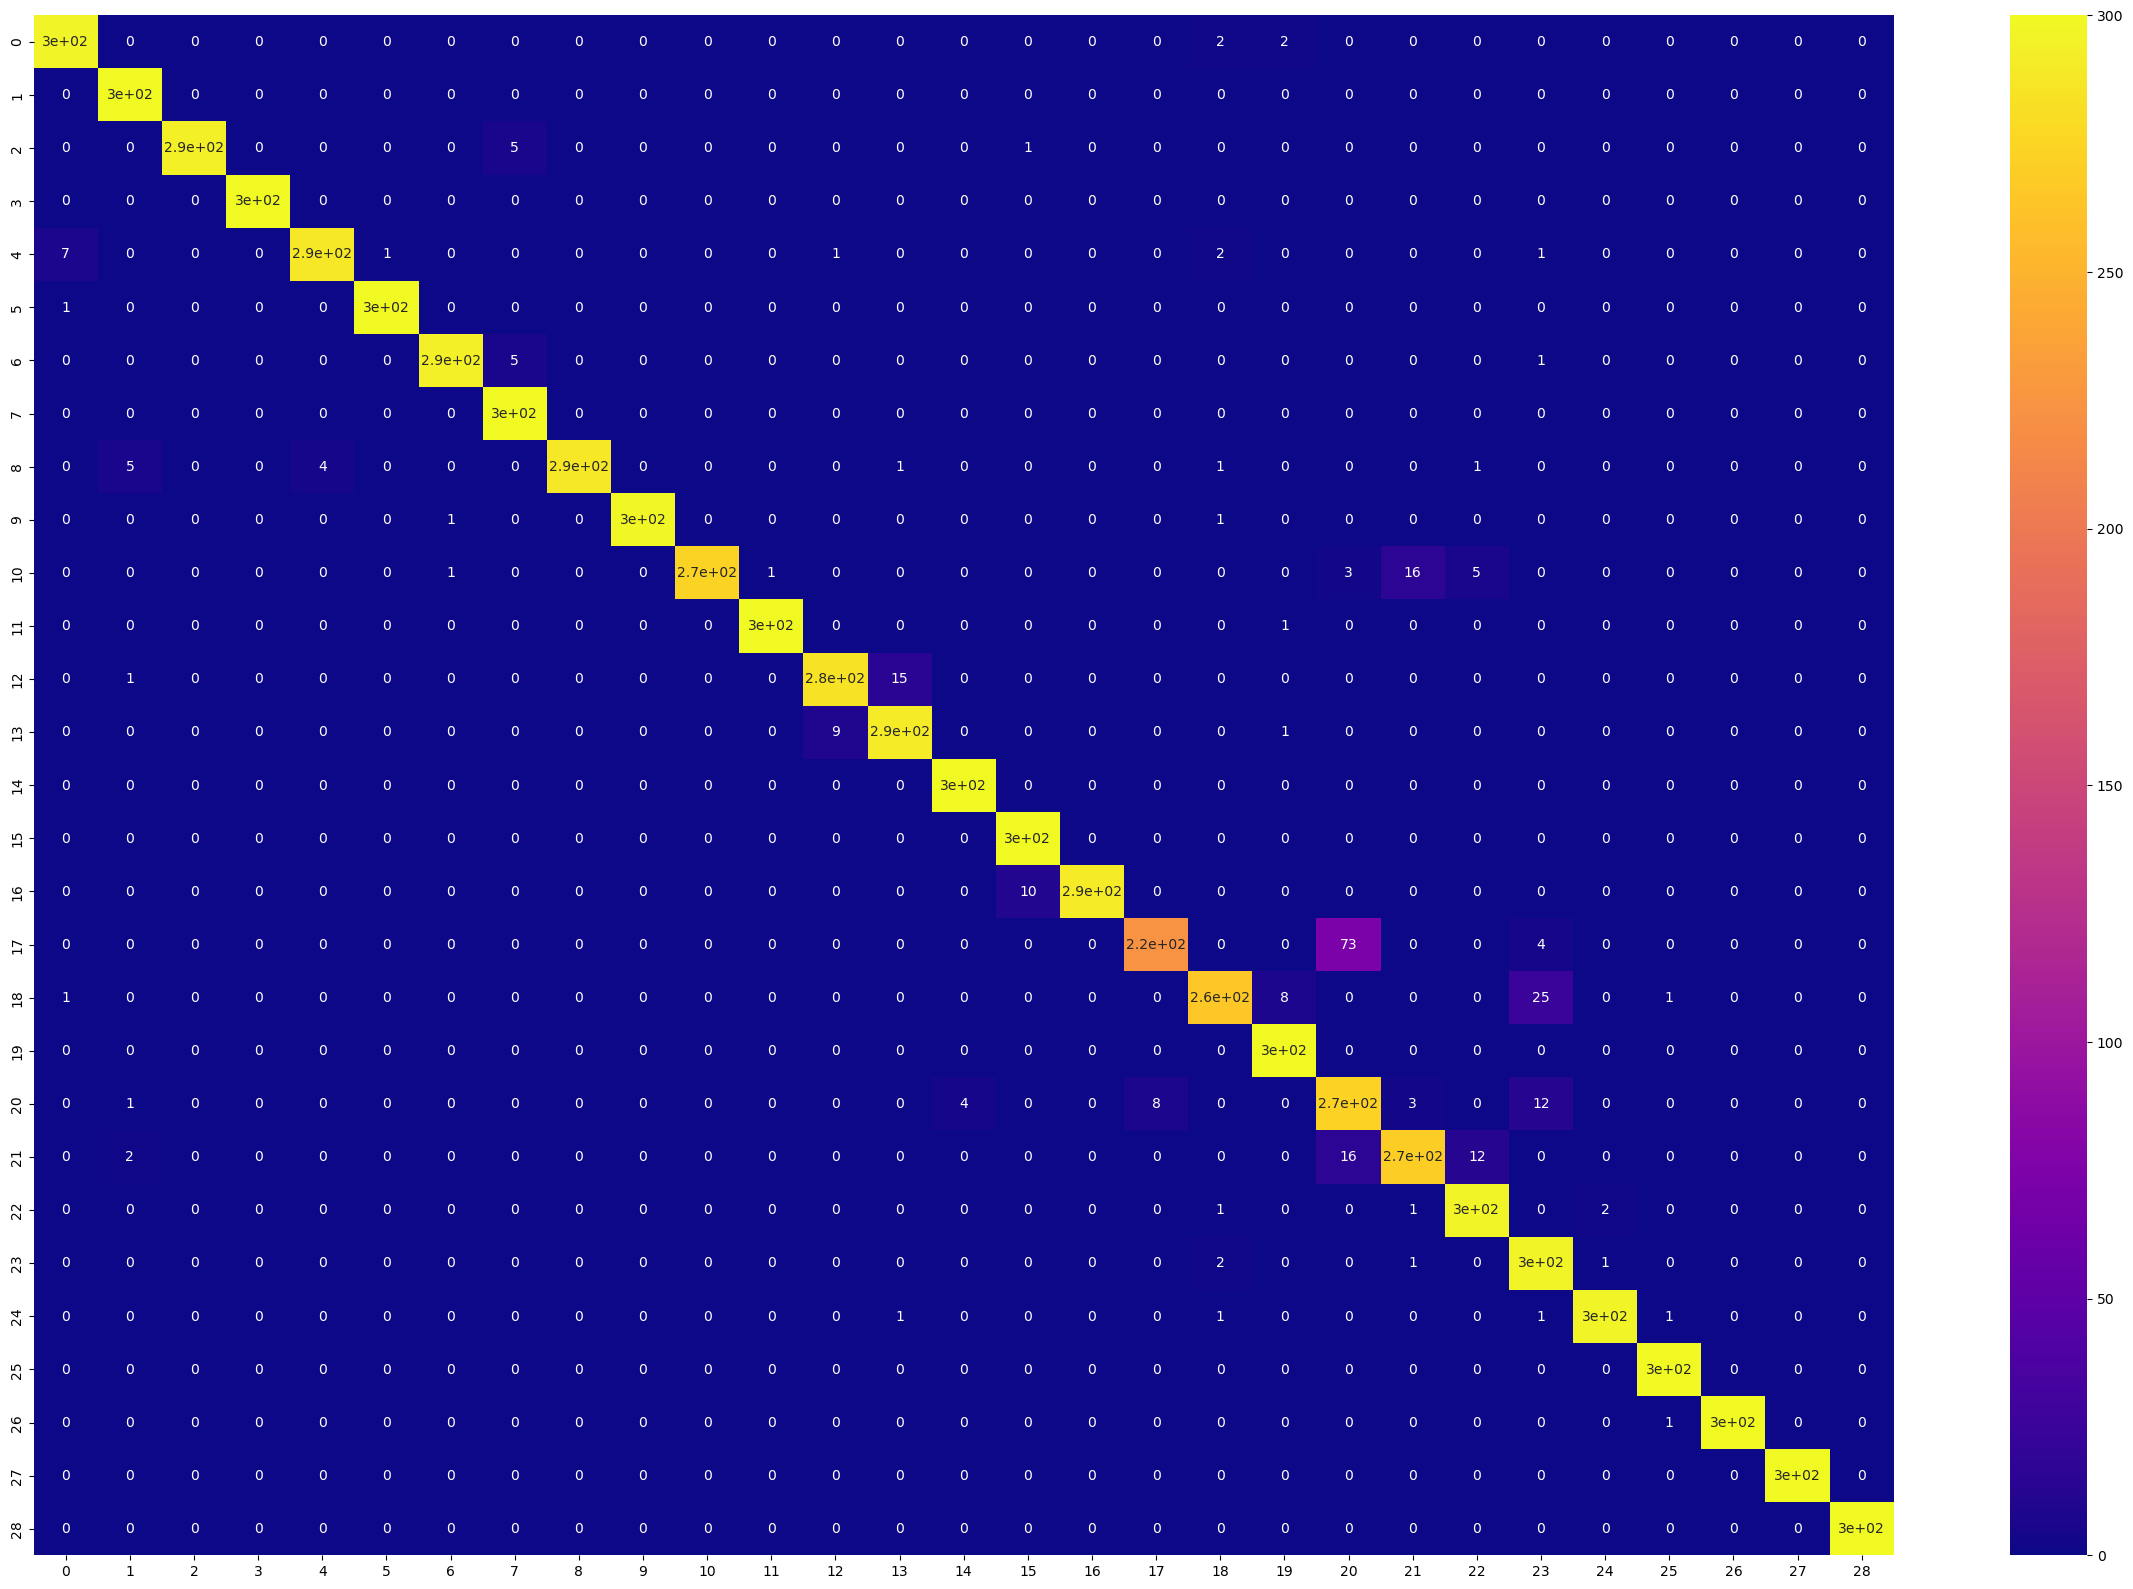

In [ ]:
plt.figure(figsize=(30, 20))
sns.heatmap(confusion, cmap="plasma", annot=True)

## Predictions

In [ ]:
decode1 = decode_label_pred(predictions(all_data_tests, model_tl), labels)

In [ ]:
display_pred(labels, decode1)

True 	 Predicted 	 Percent

A 	 A 	 100.00 %
B 	 B 	 100.00 %
C 	 C 	 100.00 %
D 	 D 	 100.00 %
E 	 E 	 99.97 %
F 	 F 	 100.00 %
G 	 G 	 99.51 %
H 	 H 	 100.00 %
I 	 I 	 100.00 %
J 	 J 	 100.00 %
K 	 K 	 99.95 %
L 	 L 	 100.00 %
M 	 M 	 98.43 %
N 	 N 	 97.66 %
O 	 O 	 100.00 %
P 	 P 	 100.00 %
Q 	 Q 	 100.00 %
R 	 R 	 88.61 %
S 	 S 	 100.00 %
T 	 T 	 100.00 %
U 	 U 	 78.33 %
V 	 V 	 99.07 %
W 	 W 	 100.00 %
X 	 X 	 99.86 %
Y 	 Y 	 99.70 %
Z 	 S 	 85.36 %
del 	 del 	 100.00 %
nothing 	 nothing 	 99.94 %
space 	 space 	 100.00 %


## Live with Opencv

In [ ]:
start_live(predict,model_tl,labels)